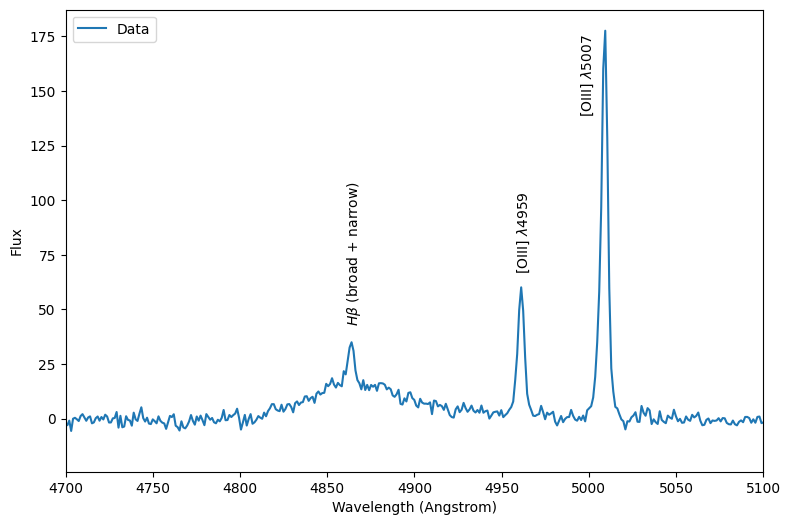

In [1]:
from model import Model
from priors import UniformPrior
import numpy as np
from astropy.io import ascii
from astropy.modeling import fitting, models
from astropy.utils.data import get_pkg_data_filename
from matplotlib import pyplot as plt

fname = get_pkg_data_filename("data/spec.txt", package="astropy.modeling.tests")
spec = ascii.read(fname)
wave = spec["lambda"]
flux = spec["flux"]

# Use the (vacuum) rest wavelengths of known lines as initial values
# for the fit.
Hbeta = 4862.721
O3_4959 = 4960.295
O3_5007 = 5008.239


# Plot the data and the fitted model
fig = plt.figure(figsize=(9, 6))
plt.plot(wave, flux, label="Data")
plt.legend(loc="upper left")
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")
plt.text(4860, 45, r"$H\beta$ (broad + narrow)", rotation=90)
plt.text(4958, 68, r"[OIII] $\lambda 4959$", rotation=90)
plt.text(4995, 140, r"[OIII] $\lambda 5007$", rotation=90)
plt.xlim(4700, 5100)
plt.show()

In [39]:
def spectral_line(x, amp, mean, std):
    return amp * np.exp(-0.5 * ((x - mean) / std) ** 2)

def OIII_emission(x, amp1, std1, std2, mean1):
    
    delta_lambda = 5007.0 - 4959.0  # 48 Å

    OIII_4959 = spectral_line(x, amp1, mean1, std1)

    OIII_5007 = spectral_line(x, amp1 / 2.98, mean1 - delta_lambda, std2)

    return OIII_4959 + OIII_5007


OIII_model = Model.wrap(OIII_emission, grid_variables=['x'], 
                        param_option = {
                            'mean1':{
                                'value':O3_5007+5,
                                'frozen':False,
                                'description':'OIII 5007 centroid',
                                'prior':UniformPrior(4800,5100),
                            },
                            'amp1':{
                                'value':100,#180,
                                'description':'OIII 5007 Amp',
                                'prior':UniformPrior(0,500),
                            },
                            'std1':{
                                'value':3.3,#2,
                                'prior':UniformPrior(0.1,5),
                                'description':'OIII 5007 std'
                                
                            },
                            'std2':{
                                'value':10,#2,
                                'prior':UniformPrior(0.1,15),
                                'description':'OIII 4959 std',
                            }
                        },
                        name = 'OIII lines'
                        )
Hbeta_1 = Model.wrap(spectral_line, grid_variables=['x'], 
                     param_option = {
                         'mean':{
                             'value':Hbeta,
                             'frozen':True,
                             'description':'Hbeta narrov centr.',
                                'prior':UniformPrior(4800,4900),
                             
                         },
                         'std':{
                           'value':.9,#2,
                           'description':'Hbeta narrov std',
                                'prior':UniformPrior(0.1,15),
                             
                         },
                         'amp':{
                             'value':100,#20,
                             'description':'Hbeta narrov Amp',
                                'prior':UniformPrior(0.1,200),
                             
                         }
                     },
                     name = 'Hbeta narrov')
Hbeta_2 = Model.wrap(spectral_line, grid_variables=['x'],
                     param_option = {
                         'mean':{
                             'value':Hbeta,
                             'frozen':True,
                             'description':'Hbeta broad centr.',
                                'prior':UniformPrior(4800,4900),
                             
                         },
                         'std':{
                           'value':11,#20,
                           'description':'Hbeta broad std',
                                'prior':UniformPrior(5,30),
                           
                         },
                         'amp':{
                             'value':5,#15,
                             'description':'Hbeta broad Amp',
                                'prior':UniformPrior(0.1,200),
                             
                         }
                     },
                     name = 'Hbeta broad')

total_model = Hbeta_1 + Hbeta_2 + OIII_model

print(total_model)

COMPOSITE MODEL NAME: CompositeModel
CONTAINED MODELS: Hbeta narrov, Hbeta broad, OIII lines
GRID VARIABLES: ['x']
LOGIC: ((Hbeta narrov [0] + Hbeta broad [1]) + OIII lines [2])
FREE PARAMS: 8
------------------------------------------------------------
  INDEX  NAME       VALUE  IS-FREE    PRIOR                      DESCR
      0  amp_0     100     Yes        Uniform(0.1, 200.0)        Hbeta narrov Amp
      1  mean_0   4862.72  No         Uniform(4.8e+03, 4.9e+03)  Hbeta narrov centr.
      2  std_0       0.9   Yes        Uniform(0.1, 15.0)         Hbeta narrov std
      3  amp_1       5     Yes        Uniform(0.1, 200.0)        Hbeta broad Amp
      4  mean_1   4862.72  No         Uniform(4.8e+03, 4.9e+03)  Hbeta broad centr.
      5  std_1      11     Yes        Uniform(5.0, 30.0)         Hbeta broad std
      6  amp1_2    100     Yes        Uniform(0.0e+00, 500.0)    OIII 5007 Amp
      7  std1_2      3.3   Yes        Uniform(0.1, 5.0)          OIII 5007 std
      8  std2_2     10

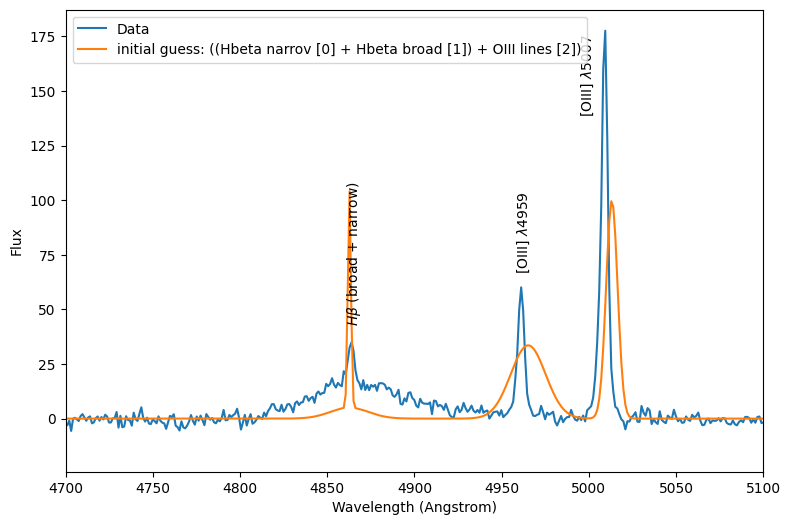

In [40]:
initial_model = total_model(wave.value)


# Plot the data and the fitted model
fig = plt.figure(figsize=(9, 6))
plt.plot(wave, flux, label="Data")
plt.plot(wave.value, initial_model, label=f"initial guess: {total_model.composite_structure()}")
plt.legend(loc="upper left")
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")
plt.text(4860, 45, r"$H\beta$ (broad + narrow)", rotation=90)
plt.text(4958, 68, r"[OIII] $\lambda 4959$", rotation=90)
plt.text(4995, 140, r"[OIII] $\lambda 5007$", rotation=90)
plt.xlim(4700, 5100)
plt.show()


In [41]:
from fitting import MCMC

fitter = MCMC(model=total_model)

results = fitter.fit(x = wave.value, 
                     data=flux.value, 
                     optimize=True,
                     nwalkers=60, 
                     nsteps=1000, 
                     burn_in=500,
                     dispersion=0.1,
                     )

theta0 is None
Optimization done, initial position is [ 1.68868583e+01  2.27979392e+00  1.54323011e+01  2.94299876e+01
  1.72199539e+02 -2.00758171e+00 -2.06236133e+00  5.00903913e+03]


  0%|          | 0/500 [00:00<?, ?it/s]/home/matteo/.pyenv/versions/3.11.6/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [00:00<00:00, 1036.07it/s]


In [42]:
print(results)

=== MCMCResult ===
    success   = True
    message   = MCMC sampling completed successfully
    discard   = 0
    thin      = 1
    ndata     = 2176
    nvarys    = 8
    chisqr    = 3.042e+04
    redchi    = 14.03
    aic       = 5755
    bic       = 5801
    best_fit:
  amp_0 = 16.9  Hbeta narrov Amp
  std_0 = 2.28  Hbeta narrov std
  amp_1 = 15.42  Hbeta broad Amp
  std_1 = 29.42  Hbeta broad std
  amp1_2 = 172.2  OIII 5007 Amp
  std1_2 = -2.024  OIII 5007 std
  std2_2 = -2.07  OIII 4959 std
  mean1_2 = 5009  OIII 5007 centroid

    Parameter summary (median [p16, p84]):
        amp_0          : 16.9 [16.83, 16.97]
        std_0          : 2.28 [2.222, 2.336]
        amp_1          : 15.42 [15.36, 15.5]
        std_1          : 29.42 [29.36, 29.5]
        amp1_2         : 172.2 [172.1, 172.3]
        std1_2         : -2.024 [-2.088, -1.942]
        std2_2         : -2.07 [-2.133, -1.997]
        mean1_2        : 5009 [5009, 5009]


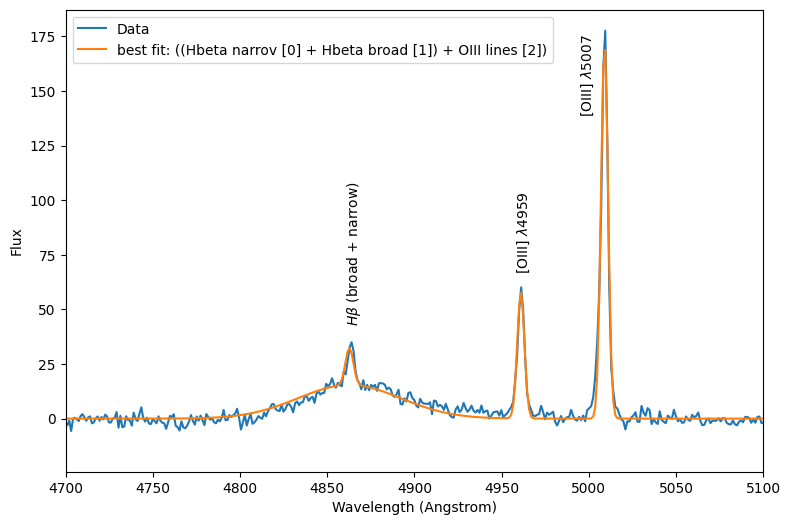

In [43]:
best_model = total_model(wave.value, **results.best_fit_dict)


# Plot the data and the fitted model
fig = plt.figure(figsize=(9, 6))
plt.plot(wave, flux, label="Data")
plt.plot(wave.value, best_model, label=f'best fit: {total_model.composite_structure()}')
plt.legend(loc="upper left")
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")
plt.text(4860, 45, r"$H\beta$ (broad + narrow)", rotation=90)
plt.text(4958, 68, r"[OIII] $\lambda 4959$", rotation=90)
plt.text(4995, 140, r"[OIII] $\lambda 5007$", rotation=90)
plt.xlim(4700, 5100)
plt.show()

# second example: constrained params

In [44]:
from parameter import TieConstrain
from model import Model
from priors import UniformPrior

Hbeta = 4862.721
O3_4959 = 4960.295
O3_5007 = 5008.239

def spectral_line(x, amp, mean, std):
    return amp * np.exp(-0.5 * ((x - mean) / std) ** 2)

OIII_5007 = Model.wrap(spectral_line, grid_variables=['x'],
                       param_option={
                           'amp':{'value':30,
                                  'prior':UniformPrior(10,200),
                                  'description': 'OIII 5007 amp'
                                  },
                           'mean':{'value':O3_5007+20,
                                   'prior':UniformPrior(O3_5007-100, O3_5007+100)},
                                    'description': 'OIII 5007 mean',
                           'std':{
                               'value':2,
                               'prior':UniformPrior(0.5,5),
                               'description': 'OIII 5007 std',
                           }
                       },
                       name = 'OIII 5007')

OIII_4959 = Model.wrap(spectral_line, grid_variables=['x'],
                       param_option={
                           'amp':{'value':50,
                                  'prior':UniformPrior(10,200),
                                  'description': 'OIII 4959 amp',                                  
                                  },
                           'mean':{'value':O3_4959-30,
                                   'prior':UniformPrior(O3_4959-100, O3_4959+100),
                                   'description': 'OIII 4959 mean',},
                           'std':{
                               'value':2,
                               'prior':UniformPrior(0.5,5),
                               'description': 'OIII 4959 std',
                           }
                       },
                       name = 'OIII 4959')

Hbeta_narrow = Model.wrap(spectral_line, grid_variables=['x'],
                       param_option={
                           'amp':{'value':100,
                                  'prior':UniformPrior(5,200),
                                  'description':'Hbeta narrow amp'
                                  },
                           'mean':{'value':Hbeta,
                                   'prior':UniformPrior(Hbeta-100, Hbeta+100),
                                   'description':'Hbeta narrow mean'},
                           'std':{
                               'value':2,
                               'prior':UniformPrior(0.5,5),
                               'description':'Hbeta narrow std'
                           }
                       },
                       name = 'Hbeta narrow')

Hbeta_broad = Model.wrap(spectral_line, grid_variables=['x'],
                       param_option={
                           'amp':{'value':33,
                                  'prior':UniformPrior(10,200),
                                  },
                           'mean':{'value':Hbeta,
                                   'prior':UniformPrior(Hbeta-100, Hbeta+100)},
                           'std':{
                               'value':15,
                               'prior':UniformPrior(0.5,20)
                           }
                       },
                       name = 'Hbeta narrow')
# apply constrains

model = (OIII_4959 + OIII_5007) + (Hbeta_broad + Hbeta_narrow)

# # set constrains
def OIII_amp(params):
    params['amp_0'] = params['amp_1'] /2.98
    return params

def OIII_mean(params):
    ratio = 4960.295 / 5008.239
    params['mean_0'] = params["mean_1"] * ratio
    return params

def tie_hbeta_to_o3(params):
    # Esempio di vincolo proporzionale simile ad Astropy:
    params['mean_3'] = params['mean_1'] * (Hbeta/O3_5007)
    return params

def tie_hbeta_comp(params):
    params['mean_2'] = params['mean_3']
    return params


# how should constrains be resolved?
model.add_constrain(TieConstrain(OIII_amp, tied_param="amp_0"))
model.add_constrain(TieConstrain(OIII_mean, tied_param='mean_0'))
model.add_constrain(TieConstrain(tie_hbeta_to_o3, tied_param='mean_3'))
model.add_constrain(TieConstrain(tie_hbeta_comp, tied_param="mean_2"))


print(model)

COMPOSITE MODEL NAME: CompositeModel
CONTAINED MODELS: OIII 4959, OIII 5007, Hbeta narrow, Hbeta narrow
GRID VARIABLES: ['x']
LOGIC: ((OIII 4959 [0] + OIII 5007 [1]) + (Hbeta narrow [2] + Hbeta narrow [3]))
FREE PARAMS: 8
------------------------------------------------------------
  INDEX  NAME      VALUE  IS-FREE    PRIOR                      DESCR
      0  amp_0     50     No         Uniform(10.0, 200.0)       OIII 4959 amp
      1  mean_0  4930.3   No         Uniform(4.9e+03, 5.1e+03)  OIII 4959 mean
      2  std_0      2     Yes        Uniform(0.5, 5.0)          OIII 4959 std
      3  amp_1     30     Yes        Uniform(10.0, 200.0)       OIII 5007 amp
      4  mean_1  5028.24  Yes        Uniform(4.9e+03, 5.1e+03)
      5  std_1      2     Yes        Uniform(0.5, 5.0)          OIII 5007 std
      6  amp_2     33     Yes        Uniform(10.0, 200.0)
      7  mean_2  4862.72  No         Uniform(4.8e+03, 5.0e+03)
      8  std_2     15     Yes        Uniform(0.5, 20.0)
      9  amp_3  

In [45]:
new_fitter = MCMC(model)

new_results = new_fitter.fit(
                x = wave.value,
               data = flux.value,
               optimize=True,
               nsteps=1000,
               burn_in=100,
               dispersion=0.1,
               nwalkers=60,
               # theta0 = [p.value for p in model.free_parameters]
               # theta0: List | Dict | None
               )



theta0 is None
Optimization done, initial position is [-2.05900364e+00  1.72231772e+02  5.00903870e+03  2.00732784e+00
  1.56318525e+01  2.92147085e+01  1.89585023e+01  1.92247449e+00]


100%|██████████| 1000/1000 [00:00<00:00, 1004.88it/s]


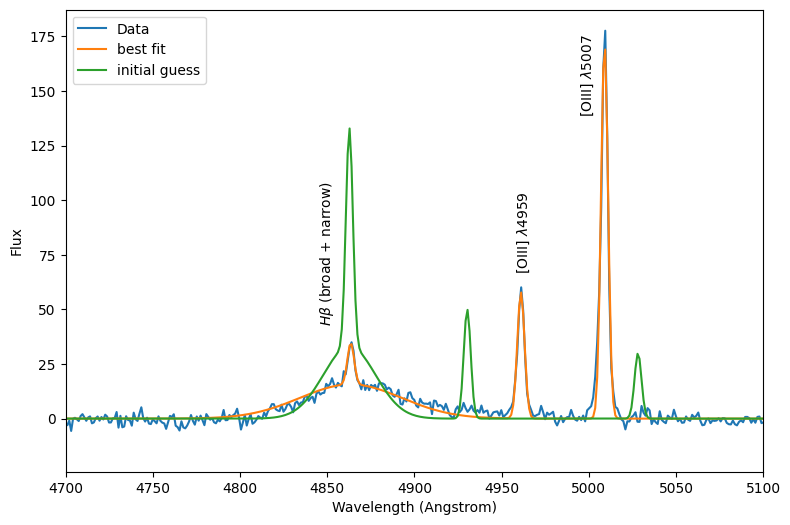

In [46]:
fig = plt.figure(figsize=(9, 6))
plt.plot(wave, flux, label="Data")
plt.plot(wave.value, model.call([wave.value], *new_results.best_fit), label='best fit')
plt.plot(wave.value, model(wave.value), label='initial guess')
plt.legend(loc="upper left")
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")
plt.text(4845, 45, r"$H\beta$ (broad + narrow)", rotation=90)
plt.text(4958, 68, r"[OIII] $\lambda 4959$", rotation=90)
plt.text(4995, 140, r"[OIII] $\lambda 5007$", rotation=90)
plt.xlim(4700, 5100)
plt.show()